# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt

# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm, notebook_tqdm

from torchtext import data
import re


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# custom path
os.chdir('..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [3]:
VOCAB = "./notebooks/vocabulary.txt"
SPE_TOKENIZER = "./models/trained/tglang_spe_unigram_10000.model"

USE_SPE = True
WITH_VOCAB = False

TRAIN_DATA = "./data/processed/tglang_train.csv"
TEST_DATA = "./data/processed/tglang_test.csv"

## Text prep

In [4]:
from collections import Counter

### Load data

In [5]:
thestack = pd.read_csv(TRAIN_DATA)
thestack = thestack.loc[~thestack["content"].isna()]
thestack["content"] = thestack["content"].astype(str)
thestack["lang"] = thestack["lang"].astype(str)

thestack.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33210 entries, 0 to 33211
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    33210 non-null  object
 1   lang       33210 non-null  object
 2   num_chars  33210 non-null  int64 
 3   num_lines  33210 non-null  int64 
 4   file       33210 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.5+ MB


In [6]:
test_set = pd.read_csv(TEST_DATA)
test_set = test_set.loc[~test_set["content"].isna()]
test_set["content"] = test_set["content"].astype(str)
test_set["lang"] = test_set["lang"].astype(str)

test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1947 entries, 0 to 1947
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    1947 non-null   object
 1   lang       1947 non-null   object
 2   num_chars  1947 non-null   int64 
 3   num_lines  1947 non-null   int64 
 4   file       1947 non-null   object
dtypes: int64(2), object(3)
memory usage: 91.3+ KB


### Load vocab

In [7]:

vocab = Path(VOCAB).read_text().split("\n")

print("Vocab size:", len(vocab))

pprint(random.choices(vocab, k=10))

Vocab size: 1461
['##',
 'no',
 'package',
 'embed',
 'jc',
 'exe',
 'constructor',
 'schema',
 'exporting',
 'to']


### Tokenizer

In [8]:
import functools
import torch

In [9]:
from torchtext.transforms import SentencePieceTokenizer

transform_sentpiece = SentencePieceTokenizer(SPE_TOKENIZER)

spe_scripted = torch.jit.script(transform_sentpiece)

In [10]:
def check_vocab(x):
    if x in VOCAB:
        return True
    else:
        return False
    
    
def split_text(x, with_vocab=WITH_VOCAB):
    x = x.lower()
    tokens = re.split("[\W']+", x)
    tokens = list(filter(bool, tokens))
    
    if with_vocab:
        tokens = list(filter(check_vocab, tokens))
    return tokens


tokenize_text = spe_scripted if USE_SPE else functools.partial(split_text, with_vocab=WITH_VOCAB)

In [13]:
smp = thestack.sample(2)

for _, row in smp.iterrows():
    tokens = tokenize_text(row["content"])
    print(f"================== {row['lang']} =================", end="\n\n")
    print(row["content"], end="\n\n")
    print("TOKENS:", Counter(tokens), sep="\n", end="\n\n")

================== TGLANG_LANGUAGE_HTML =================

              <a href="structStdString.html" class="m-doc">StdString</a> <a href="#a73b7ffc82397ab05ff8c2d12c31cc2c7" class="m-doc-self">m_path</a>
            </dt>
            <dd>the string representation of the path</dd>
          </dl>
        </section>
      </div>
    </div>
  </div>
</article></main>
<div class="m-doc-search" id="search">
  <a href="#!" onclick="return hideSearch()"></a>
  <div class="m-container">
    <div class="m-row">

TOKENS:
Counter({'>': 12, '="': 8, '▁<': 7, 'a': 7, '-': 7, '▁</': 7, 'm': 6, 'div': 6, '▁class': 5, '">': 5, 'c': 4, '▁href': 3, '"': 3, 'doc': 3, '</': 3, 'S': 2, 'td': 2, 'String': 2, '="#': 2, 'ff': 2, '8': 2, '2': 2, 'dd': 2, 'search': 2, 'struct': 1, '.': 1, 'html': 1, '73': 1, 'b': 1, '7': 1, '23': 1, '97': 1, 'ab': 1, '05': 1, 'd': 1, '12': 1, '31': 1, 'cc': 1, '7"': 1, 'self': 1, '_': 1, 'path': 1, 'dt': 1, 'the': 1, '▁string': 1, '▁representation': 1, '▁of': 1, '▁the': 1, '

## Experiments

**Hyper-parameters:**
- [x] topics: primary only, primary + secondary
- [x] inputs: title, description, posts
- [x] preprocessing: raw, lemmas
- [x] vectorizers: tf-idf, bow
- [x] clf: xgb, nb, etc.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

# from xgboost import XGBClassifier

import itertools

In [15]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, input_fields, preprocessing, vect, est):
        self.INPUT_FIELDS = input_fields
        self.vect = VECTORIZERS[vect]
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        assert preprocessing in ['raw']
        self.preprocessing = preprocessing
        
    def prepare_data(self, is_final):
        # combine fields
        data = thestack.copy()
        data["text"] = thestack.apply(lambda x: " ".join([x[f] for f in self.INPUT_FIELDS]),
                                      axis=1)
        # split into  train and test
        one, self.test_inputs = train_test_split(data, test_size=0.2, random_state=24, shuffle=True,)
        comb_datasets = [one, self.test_inputs] if is_final else [one]
        self.train_inputs = pd.concat(comb_datasets, axis=0)
        # x and y
        self.y_train = self.train_inputs['lang']
        self.y_test = self.test_inputs['lang']
        self.X_train = self.vect.fit_transform(self.train_inputs['text'])
        self.X_test = self.vect.transform(self.test_inputs['text'])
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        # fit and eval
        self.clf.fit(self.X_train, self.y_train)
        self.predictions = pd.DataFrame({
                    'true': trainer.test_inputs['lang'],
                    'predicted': trainer.clf.predict(trainer.X_test)
                })
        score = self.predictions.apply(lambda x: x['predicted'] == x['true'], axis=1).mean()
        return score
    
    def predict(self, inputs):
        tokens = self.vect.transform(inputs)
        return self.clf.predict(tokens)
        
    @staticmethod
    def score(predictions, gt):
        return (predictions == gt).mean()

### Set hyper-parameters

In [16]:
INPUTS = [
    'content',
#     "punct",
]

PREPROCESSING = [
    'raw',
]

vect_params = dict(
    max_df=0.25, 
    min_df=3,
    max_features=1000,
    binary=False, 
    ngram_range=(1,1), 
    stop_words=None,
#     tokenizer= lambda x: re.split(),
    tokenizer=tokenize_text,
    
)
VECTORIZERS = {
    'tfidf': TfidfVectorizer(**vect_params),
    'bow': CountVectorizer(**vect_params),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
    cnb = ComplementNB(),
    mnb = MultinomialNB(),
)

In [17]:
input_combinations = [INPUTS] #list(itertools.combinations(INPUTS, r=2)) + [INPUTS]

train_params = list(itertools.product( 
                                input_combinations,
                                      PREPROCESSING,
                                VECTORIZERS.keys(), 
                                ESTIMATORS.keys()))

len(train_params)

4

### Run experiments

In [18]:
X_test = test_set["content"]
y_test = test_set["lang"]


In [19]:
results = []

for params in notebook_tqdm(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    val_score = trainer.run_eval()
    test_score = trainer.score(trainer.predict(X_test), y_test)
    score = (val_score + test_score * 2) / 3
    params += (val_score, test_score, score)
    results.append(params)
                
results = pd.DataFrame(results, columns=['input_fields', 'preprocessing','vect', 'est', 
                                         'val_score', "test_score", "score"])

# experiments:   0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
# experiments:  25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:01<00:05,  1.75s/it]/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
# experiments:  50%|██████████████████████████████████████████████████████████████████████████▌                                               

In [20]:
print(results.sort_values('score', ascending=False).to_markdown())

|    | input_fields   | preprocessing   | vect   | est   |   val_score |   test_score |    score |
|---:|:---------------|:----------------|:-------|:------|------------:|-------------:|---------:|
|  1 | ['content']    | raw             | tfidf  | mnb   |    0.795995 |     0.77093  | 0.779285 |
|  3 | ['content']    | raw             | bow    | mnb   |    0.795845 |     0.697997 | 0.730613 |
|  0 | ['content']    | raw             | tfidf  | cnb   |    0.688497 |     0.701592 | 0.697227 |
|  2 | ['content']    | raw             | bow    | cnb   |    0.66486  |     0.676425 | 0.67257  |


### Review errors

In [21]:
from sklearn.metrics import top_k_accuracy_score

#### Train

In [22]:
best_params = results.sort_values("score", ascending=False).iloc[0].to_dict()
best_params.pop("score"), best_params.pop("val_score"), best_params.pop("test_score")

(0.7792848176156246, 0.795995182174044, 0.770929635336415)

In [23]:
trainer = Trainer(**best_params)
s = trainer.run_eval(final=False)
print(s)

/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.795995182174044


#### Classification report

In [24]:
from sklearn.metrics import classification_report

In [25]:

test_pred = trainer.predict(X_test)

is_wrong = test_pred != y_test

errors = test_set.loc[is_wrong]

errors['predicted'] = test_pred[is_wrong]

/var/folders/fg/vxz9bx5n1vvb2p8k4cr_wc9h0000gp/T/ipykernel_68643/2620725147.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['predicted'] = test_pred[is_wrong]


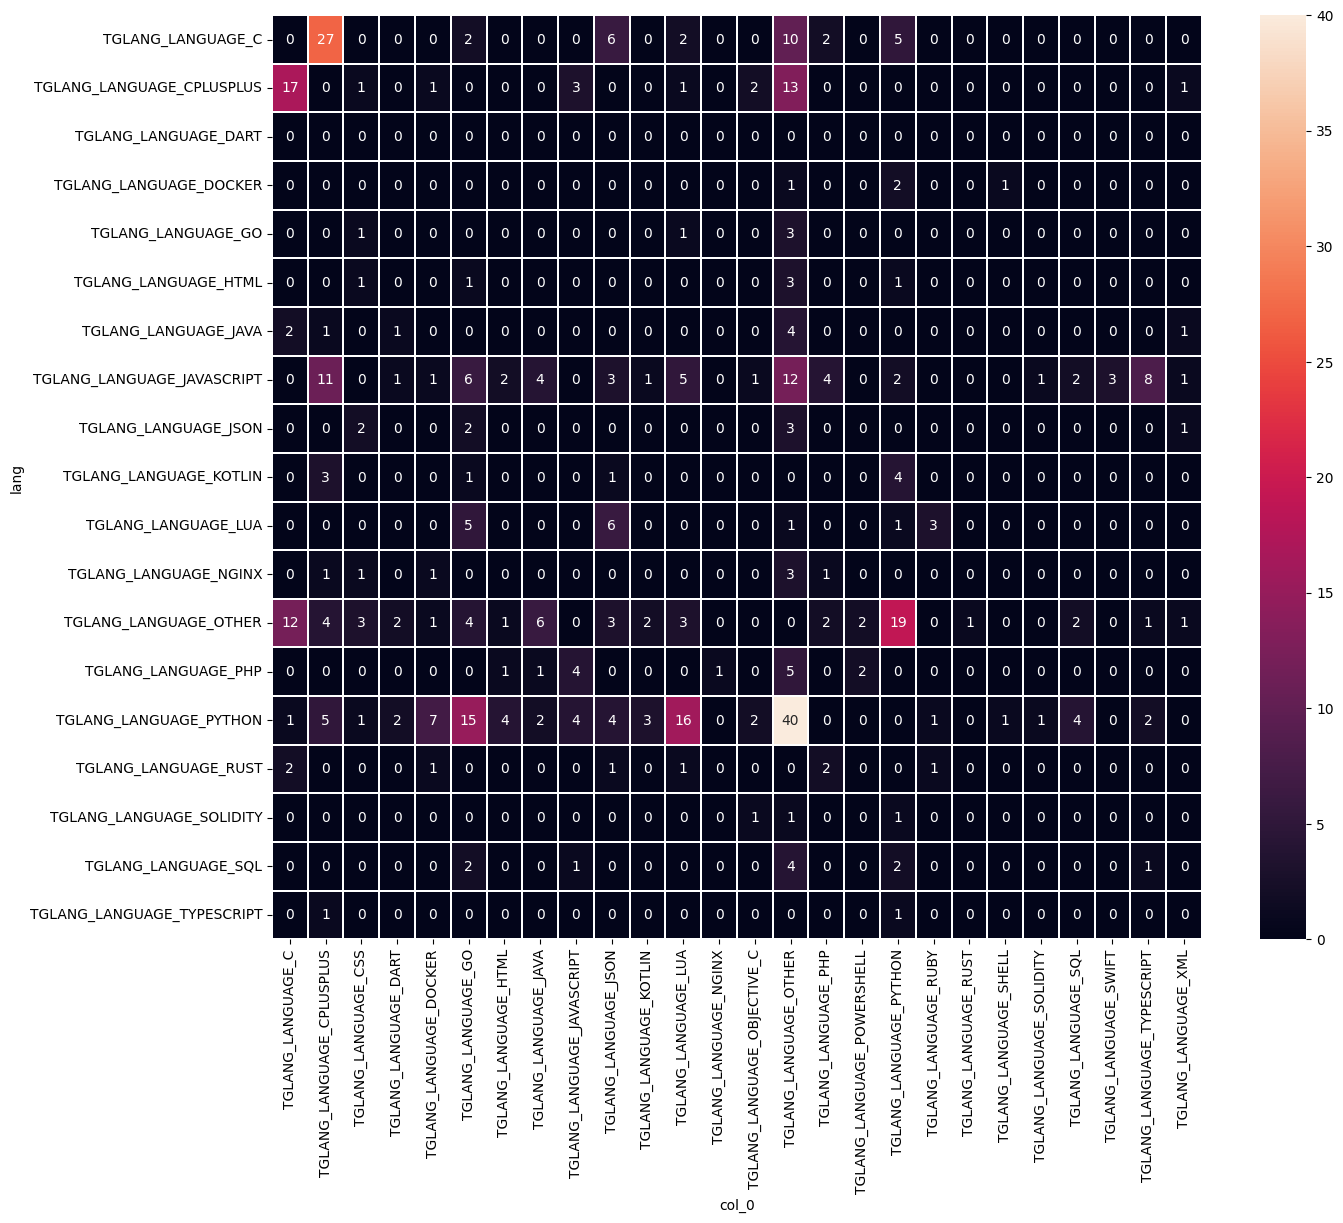

In [26]:
ct = pd.crosstab(y_test, test_pred)
for i,k in ct.iterrows():
    k[i] = 0


plt.figure(figsize=(15,12))
sns.heatmap(ct, annot=True, linewidths=0.01);

In [27]:
metrics = pd.DataFrame(classification_report(y_test, test_pred, output_dict=True, zero_division=0)).T

metrics = metrics.query("support > 0").sort_values('f1-score', ascending=True)

print(metrics.to_markdown())

|                            |   precision |   recall |   f1-score |    support |
|:---------------------------|------------:|---------:|-----------:|-----------:|
| TGLANG_LANGUAGE_TYPESCRIPT |   0.0769231 | 0.333333 |   0.125    |    3       |
| TGLANG_LANGUAGE_SQL        |   0.2       | 0.166667 |   0.181818 |   12       |
| TGLANG_LANGUAGE_C          |   0.227273  | 0.15625  |   0.185185 |   64       |
| TGLANG_LANGUAGE_GO         |   0.22449   | 0.6875   |   0.338462 |   16       |
| TGLANG_LANGUAGE_LUA        |   0.325581  | 0.466667 |   0.383562 |   30       |
| TGLANG_LANGUAGE_DART       |   0.25      | 1        |   0.4      |    2       |
| macro avg                  |   0.417031  | 0.443086 |   0.404786 | 1947       |
| TGLANG_LANGUAGE_DOCKER     |   0.4       | 0.666667 |   0.5      |   12       |
| TGLANG_LANGUAGE_KOTLIN     |   0.571429  | 0.470588 |   0.516129 |   17       |
| TGLANG_LANGUAGE_JAVASCRIPT |   0.789474  | 0.39823  |   0.529412 |  113       |
| TGLANG_LANGUAG

#### Errors

In [28]:
TRUE_CLASS = "TGLANG_LANGUAGE_PYTHON"
PRED_CLASS = None  # "TGLANG_LANGUAGE_C"

class_errors = test_set.loc[(y_test == TRUE_CLASS) & 
                                   ((test_pred == PRED_CLASS ) if PRED_CLASS else (test_pred != TRUE_CLASS))
                                  ]

for _, row in class_errors.iterrows():
    print("="*10, row["lang"], "="*10, end="\n\n")
    print(row["content"], end="\n\n")
    tokens = tokenize_text(row["content"],)
    print("VOCAB:", Counter([t for t in tokens if t in trainer.vect.vocabulary_]))
    
# print(*class_errors["content"].sample(3).tolist(), sep="\n\n=================================\n\n")

========== TGLANG_LANGUAGE_PYTHON ==========

from aiogram.fsm.state import State, StatesGroup

VOCAB: Counter({'▁from': 1, '▁a': 1, 'io': 1, 'g': 1, 'f': 1, 'sm': 1, 'state': 1, '▁import': 1, 'Group': 1})
========== TGLANG_LANGUAGE_PYTHON ==========

bash
   pip install virtualenv

VOCAB: Counter({'▁install': 1, 'env': 1})
========== TGLANG_LANGUAGE_PYTHON ==========

    for bot in bots:
        bot.disconnect()
        bot.close()
names = ["Вера Ли", "Анна Романова", "Ульяна Борко ", "Макс Гаврилов", "Сергей Назаренко", "Надежда Горбунова",
         "Владислав Цветков ", "Misha Makarov", "Алла Митина ", "Тимофей Курьянов", "Кирилл Кривцов", "Женя Сараджева ",
         "Анатолий Баранов", "Мухаммад Сафин", "Vlad Sig",
         "Степан Муравьев", "Александр Ананьев",

VOCAB: Counter({'а': 21, '▁"': 20, 'в': 15, '",': 13, 'н': 12, 'е': 10, 'и': 7, 'о': 6, 'р': 6, 'л': 5, 'д': 5, 'ра': 4, 'м': 4, 'но': 4, 'С': 4, 'у': 4, 'я': 3, 'ко': 3, 'с': 3, 'ри': 3, 'й': 3, 'ла': 3, 'ь': 3, 'd': 2,

#### Vocab

In [30]:
trainer.vect.vocabulary_

{'▁void': 975,
 'dir': 389,
 'M': 238,
 'F': 205,
 '&': 19,
 '▁const': 836,
 '▁std': 942,
 '::': 152,
 'string': 565,
 'Path': 258,
 ');': 42,
 '();': 37,
 '▁private': 920,
 '▁list': 892,
 'File': 207,
 '▁*/': 701,
 'String': 275,
 '▁Get': 760,
 '()': 32,
 '{': 622,
 '▁return': 929,
 '▁m': 895,
 ';': 154,
 '▁/**': 710,
 '▁*': 700,
 '▁<': 741,
 'p': 519,
 '>': 161,
 '▁of': 910,
 '▁the': 951,
 '▁bool': 821,
 '▁|': 987,
 '0.00': 55,
 '%': 18,
 '▁1': 718,
 'P': 254,
 'an': 329,
 'ca': 356,
 'ke': 465,
 'V': 293,
 '2': 83,
 '▁10': 720,
 '▁U': 790,
 '▁F': 757,
 '▁///': 712,
 '▁The': 788,
 '▁`': 802,
 '<': 155,
 'T': 279,
 '`': 315,
 '),': 40,
 '▁A': 749,
 '▁e': 849,
 'g': 418,
 '▁S': 782,
 '▁map': 896,
 'B': 175,
 'Map': 240,
 'K': 233,
 '▁V': 791,
 '▁package': 916,
 '▁org': 913,
 'fa': 408,
 'ir': 455,
 'y': 620,
 't': 568,
 '▁import': 878,
 'a': 316,
 'A': 166,
 'Group': 212,
 'Event': 203,
 'In': 225,
 'i': 434,
 '▁java': 886,
 'util': 605,
 'Array': 174,
 'List': 237,
 '▁//': 711,
 'ent'

## Save models

In [31]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple, Any

In [32]:
LANG_ENUM = Path("./src/tglang/langs_enum_r2.txt").read_text().split('\n')
LANG_ENUM = [l.strip() for l in LANG_ENUM]

In [33]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.clf_labels = clf.classes_.tolist()
        self.target_labels = LANG_ENUM
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        jll = torch.matmul(x.double(), self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.logsumexp(jll, dim=1)
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vect, vectorizer):
        super().__init__()
        assert vect in ['bow','tfidf']
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        if vect == 'tfidf':
            self.idf_diag = nn.Parameter(
                torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
                requires_grad=False)
            self.sublinear_tf = vectorizer.sublinear_tf
            self.norm = vectorizer.norm
            self.use_idf = vectorizer.use_idf
        else:
            self.idf_diag = nn.Parameter(torch.eye(self.vocab_len))
            self.sublinear_tf = False
            self.norm = None
            self.use_idf = False
            
        

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.long)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [
            self.count_vocab(doc)
            for doc in batch
        ]
        X = torch.stack(doc_counts,)
        if self.sublinear_tf:
            X = torch.log(X.double())
            X += 1
        if self.use_idf:
            X = torch.matmul(X.double(), self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X.double(), p=p, dim=1)
        return X
    

class TgLang(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf):
        super().__init__()
        self.vect = vect
        self.clf = clf
        
        
    def select_top_class(self, probs: torch.Tensor) -> int:
        """ select classes with at least min prob and return a normalized dict mapping """
        if self.clf.nb == 'cnb' and probs.std(0) < 0.0001:
            return 0
        elif self.clf.nb == 'mnb' and probs.max() < 0.001:
            return 0
        max_index = torch.argmax(probs, 0)
        class_label = self.clf.clf_labels[max_index.item()]
        return self.clf.target_labels.index(class_label)
        
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[int]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_class(probs[i]) for i in range(probs.size(0))]
        return top_predictions

### Test

In [34]:

trainer = Trainer(**best_params)
_ = trainer.run_eval(final=True)

tglang = TgLang(
    TextVectorizer(best_params["vect"], trainer.vect),
    NaiveBayes(best_params["est"], trainer.clf),
)

# torchscript
tglang = torch.jit.script(tglang)


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [35]:
seq = nn.Sequential(
    spe_scripted,
    tglang
)


In [39]:

batch = test_set.sample(5)
inputs = batch["content"].tolist()
gt = batch["lang"].tolist()



predictions = seq(inputs)

for inp, out, index in zip(inputs, gt, predictions):
    print(f"Predicted {LANG_ENUM[index]!r}. "
          f"True: {out!r}", 
          end="\n\n")
    print(inp)
    print("="*50, end="\n\n")

Predicted 'TGLANG_LANGUAGE_PHP'. True: 'TGLANG_LANGUAGE_PHP'

function dd(mixed $data, bool $exit = true): void{
    echo  '<pre>';
    print_r($data);
    echo  '</pre>';
    if ($exit){
        exit;

Predicted 'TGLANG_LANGUAGE_OTHER'. True: 'TGLANG_LANGUAGE_OTHER'

✅INDOSAT REGULER PROMO
🪵 IP5              5.665  
🪵 IP10            10.460   
🪵 IP15            14.785                
🪵 IP20            19.500          
🪵 IP25            24.575          
🪵 IP30            29.350         
🪵 IP40            38.975         

Predicted 'TGLANG_LANGUAGE_PYTHON'. True: 'TGLANG_LANGUAGE_PYTHON'

class Solution:
    def maxDotProduct(self, a: List[int], b: List[int]) -> int:
        return(f:=cache(lambda i,j,k:max(a[i]*b[j]+f(i+1,j+1,1),f(i+1,j,k),f(i,j+1,k))if a[i:]and b[j:]else not k and-inf))(0,0,0)

Predicted 'TGLANG_LANGUAGE_OTHER'. True: 'TGLANG_LANGUAGE_OTHER'

دمت يا اقصى لنا يا وصية الرسول🤍
والظلام لن يطول🇵🇸

Predicted 'TGLANG_LANGUAGE_CPLUSPLUS'. True: 'TGLANG_LANGUAGE_CPLUSPLUS'

  

### Final training, convert and save

In [40]:

path = 'models/trained/tglang.pt'
tokenizer_path = path.replace("tglang.pt", "tglang_tokenizer.pt")
torch.jit.save(tglang, path)
torch.jit.save(spe_scripted, tokenizer_path)
print('saved to', path)

saved to models/trained/tglang.pt


#### Test jit

In [41]:
tokenizer = torch.jit.load(tokenizer_path)
model = torch.jit.load(path)

model

RecursiveScriptModule(
  original_name=TgLang
  (vect): RecursiveScriptModule(original_name=TextVectorizer)
  (clf): RecursiveScriptModule(original_name=NaiveBayes)
)

##### Check other

In [42]:

model_input = test_set[test_set["lang"] == LANG_ENUM[0]]["content"].sample(4).tolist()
model_out = model(tokenizer(model_input))

for x, y in zip(model_input, model_out):
    print("="*10, LANG_ENUM[y], "="*10)
    print(x, end='\n\n')

========== TGLANG_LANGUAGE_OTHER ==========
15:15 BTC/USD PUT  ✅
20:30 BTC/USD CALL ✅¹
22:00 BTC/USD CALL ✅
23:15 BTC/USD CALL ✅

========== TGLANG_LANGUAGE_OTHER ==========
🚀 Мы ценим ваше время и предоставляем платформу для размещения объявлений без лишних обсуждений и советов.
Просто делитесь информацией о вашем товаре или услуге.

========== TGLANG_LANGUAGE_OTHER ==========
Odoo Server Error

========== TGLANG_LANGUAGE_OTHER ==========
1028808期 1+5+3=09 小单虎
1028807期 3+2+5=10 小双虎
1028806期 5+3+4=12 大双龙
1028805期 2+1+3=06 小双虎
1028804期 2+5+3=10 小双虎
1028803期 6+6+1=13 大单龙



##### Check lang

In [43]:

model_input = test_set[test_set["lang"] != LANG_ENUM[0]]["content"].sample(4).tolist()
model_out = model(tokenizer(model_input))

for x, y in zip(model_input, model_out):
    print("="*10, LANG_ENUM[y], "="*10)
    print(x, end='\n\n')

========== TGLANG_LANGUAGE_OTHER ==========
for i in range(1, num_steps):
    x[i], y[i], vx[i], vy[i] = verlet_integration(x[i-1], y[i-1], vx[i-1], vy[i-1], dt)
# Вывод результатов
plt.plot(x, y)
plt.xlabel("x (м)")
plt.ylabel("y (м)")
plt.title("Траектория движения электрона")
plt.show()

========== TGLANG_LANGUAGE_PYTHON ==========
python
def calculate_hypotenuse(leg1, leg2):
    leg1_squared = leg1 ** 2
    leg2_squared = leg2 ** 2
    sum_of_squares = leg1_squared + leg2_squared
    hypotenuse = sum_of_squares ** 0.5
    return hypotenuse

========== TGLANG_LANGUAGE_LUA ==========
            cout<<"Sizning balansingizda "<<balans<< " so'm pul qoldi
";
        }
        }
    }else{
        popitka++;
        cout<<"pin xato terildi boshqatan urinib ko'ring
";
        goto boshiga;
   }
    }

========== TGLANG_LANGUAGE_OBJECTIVE_C ==========
    break;
case 3:
    cout<<"Chorshanba
";
  break;
case 4:
    cout<<"Payshanba



### Check file sizes

In [44]:
!du -h models/trained/* | sort -nr

440K	models/trained/tglang_spe_word_10000.torchscript
436K	models/trained/tglang_spe_word_10000.model
384K	models/trained/tglang_tokenizer.pt
384K	models/trained/tglang_spe_unigram_10000.torchscript
380K	models/trained/tglang_spe_unigram_10000.model
256K	models/trained/tglang_spe_word_1000.torchscript
256K	models/trained/tglang_spe.torchscript
256K	models/trained/tglang_spe.model
252K	models/trained/tglang_spe_word_1000.model
244K	models/trained/tglang_spe_unigram_1000.model
212K	models/trained/tglang_spe_word_10000.vocab
156K	models/trained/tglang_spe_unigram_10000.vocab
 20K	models/trained/tglang_spe_word_1000.vocab
 20K	models/trained/tglang_spe.vocab
 16K	models/trained/tglang_spe_unigram_1000.vocab
9.1M	models/trained/tglang.pt
1.1M	models/trained/tokenizer.json
